In [31]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.feature_selection import SelectPercentile

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA,KernelPCA

import lightgbm as lgb
import xgboost as xgb
from sklearn.externals import joblib

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,confusion_matrix

train=pd.read_csv(r'C:\D\Tianchi\used_car_train_20200313\used_car_train_20200313.csv',sep=' ')
testA=pd.read_csv(r'C:\D\Tianchi\used_car_testA_20200313\used_car_testA_20200313.csv',sep=' ')
numeric_label=train.select_dtypes(exclude= ['object']).columns
feature=[col for col in numeric_label if col not in ['SaleID', 'name','regDate','seller','creatDate', 'offerType','price','model']]
target='price'
X_data=train[feature]
X_data['Time']=(-train['regDate']+train['creatDate'])/(10*0.2e5)
Y_data=train[target]
TestA=testA[feature]
X_data=X_data.fillna(-1)
Y_data=Y_data.fillna(-1)
TestA['Time']=(-testA['regDate']+testA['creatDate'])/(10*0.2e5)
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)


In [33]:
x_train.iloc[0:3,:]

,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,v_0,v_1,v_2,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,Time
8365,1,0.0,1.0,0.0,140,15.0,2705,45.982543,-3.231726,-0.066601,...,0.000391,0.119175,0.081993,0.036299,2.03101,-2.584468,1.847911,-0.865729,-0.243204,0.596070
86178,22,6.0,1.0,1.0,140,12.5,3016,46.532821,4.929408,-0.899810,...,0.115272,0.000000,0.061250,0.099625,-5.58686,0.043852,0.347689,0.969824,-2.718273,0.500500
124867,13,-1.0,0.0,0.0,77,15.0,2536,35.590357,-3.493483,16.017459,...,0.000476,1.156063,0.096878,0.053818,9.74832,14.301918,6.650899,1.950970,0.543338,0.500015


In [28]:
from sklearn.feature_selection import SelectPercentile
select=SelectPercentile(percentile=70)
select.fit(x_train,y_train)
x_train=select.transform(x_train)
select.fit(x_val,y_val)
x_val=select.transform(x_val)

In [26]:
x_val.shape

(45000, 24)

In [25]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, gamma=0.06, subsample=0.8,\
        colsample_bytree=1, max_depth=11) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16'] ['brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'regionCode', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'Time', 'name']
expected f1, f2, f3, f4, f7, f5, f9, f12, f16, f6, f11, f13, f0, f8, f10, f15, f14 in input data
training data did not have the following fields: v_5, name, v_10, v_0, Time, v_9, v_11, fuelType, v_13, brand, power, v_6, v_1, v_4, v_2, v_7, regionCode, v_3, bodyType, v_14, v_12, gearbox, kilometer, v_8

In [29]:
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

MAE of val with xgb: 3040.513166031901


[False  True  True  True  True  True False  True False False  True  True
  True  True  True  True  True  True  True  True False False  True False]


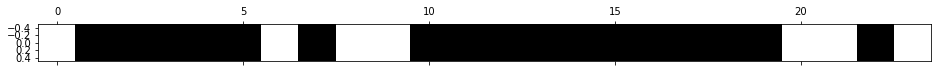

In [14]:
mask = select.get_support()
print(mask)
# 将遮罩可视化——黑色为True，白色为False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')